In [3]:
import torch 
import torchvision
from torchvision import datasets, transforms # standard pkg that has datasets and transforms
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import datasets
"""
Import functional modules and neural networl impl from Pytorch
"""
from torch import nn
import torch.nn.functional as F

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([transforms.Resize((28,28)), # resize for validation
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# training_dataset     
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# validation dataset
# mainly for testing purposes
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [7]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # convert data into numpy array
    image = image.transpose(1, 2, 0)
#    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

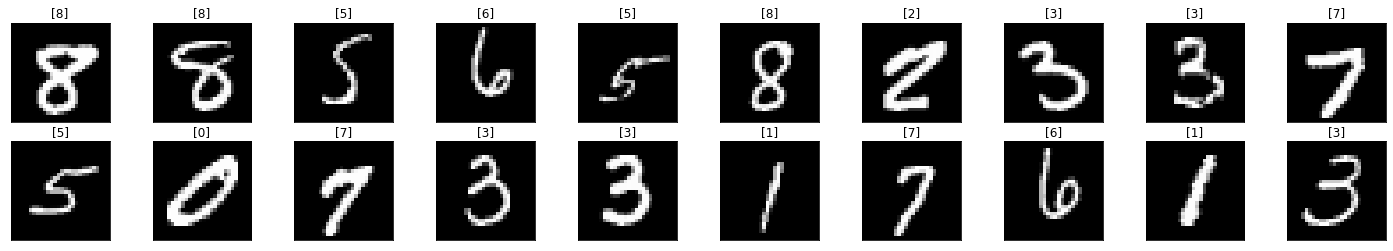

In [8]:
# Create object that allows iterable to run
dataiter = iter(training_loader)
images, labels = dataiter.next()
#images = images.to(device)
#labels = labels.to(device)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [9]:
# Neural Network Implementation on Image Recog (S7 #7) - 09162020
class LeNet(nn.Module):
    def __init__(self): # n of input node, no. of nodes in 1st input layer, no. of nodes in 2nd input layer, no. of nodes in output layer
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # n input channel, n output, n kernel size, n stride length
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500) # 4 * 4 * 50 ~ layer has 50 channels, each has a 4 * 4 dimension img, 500 nodes
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10) # output has 10 classes need to be classified, 500 img input
            
    def forward(self, X): 
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # X = feed forward value, 2 by 2 kernel
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 4*4*50) # n cols, n rows
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)
        X = self.fc2(X)
        return X

model = LeNet()

In [10]:
# Continue 10/07/2020 (evening)
model = LeNet().to(device) # 28 px * 28 px = 784 pixels for MNIST(784 nodes necesary)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # tips, start with a high learning rate then adjust based on results whether loss fluctuates or not (skewness)

In [12]:
epochs = 15
running_loss_history = []
running_corrects_history = []
# validation running history
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
            
    running_loss = 0.0
    running_corrects = 0.0     
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # remove flattening as we're inputting full dimensional layer of image
#        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    else:
        # save memory
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                # remove flattening as we're inputting full dimensional layer of image                
#                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
            
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
        
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        print("epoch: ", e+1)
    
        if(e == 14):
            print("Finished!")

        print("training loss: {:.4f}, training correct: {:.4f}".format(epoch_loss, epoch_acc.item()))
        print("validation loss: {:.4f}, validation correct: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))        

epoch:  1
training loss: 0.5779, training correct: 84.5233
validation loss: 0.1779, validation correct: 94.7500
epoch:  2
training loss: 0.1506, training correct: 95.6033
validation loss: 0.1053, validation correct: 96.8700
epoch:  3
training loss: 0.1025, training correct: 96.9783
validation loss: 0.0806, validation correct: 97.3700
epoch:  4
training loss: 0.0811, training correct: 97.5717
validation loss: 0.0620, validation correct: 98.0400
epoch:  5
training loss: 0.0668, training correct: 98.0250
validation loss: 0.0557, validation correct: 98.2700
epoch:  6
training loss: 0.0583, training correct: 98.2317
validation loss: 0.0494, validation correct: 98.5500
epoch:  7
training loss: 0.0510, training correct: 98.4100
validation loss: 0.0429, validation correct: 98.6900
epoch:  8
training loss: 0.0455, training correct: 98.6217
validation loss: 0.0383, validation correct: 98.7400
epoch:  9
training loss: 0.0409, training correct: 98.7633
validation loss: 0.0377, validation correct: 

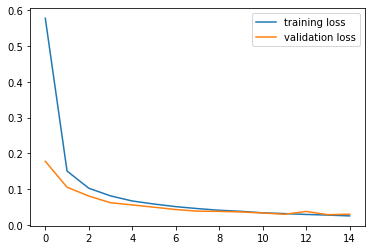

In [13]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()
#plt.plot(running_corrects_history, label="training accuracy")

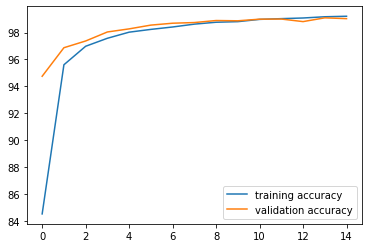

In [14]:
plt.plot(running_corrects_history, label="training accuracy")
plt.plot(val_running_corrects_history, label="validation accuracy")
plt.legend()

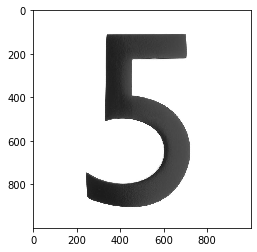

In [15]:
# Final tests (09222020)
import requests
import PIL.ImageOps
from PIL import Image
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'

response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
#print(response)

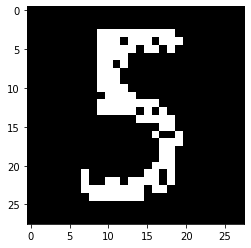

In [16]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [17]:
# remove flattening
#img = img.view(img.shape[0], -1)
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)

output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


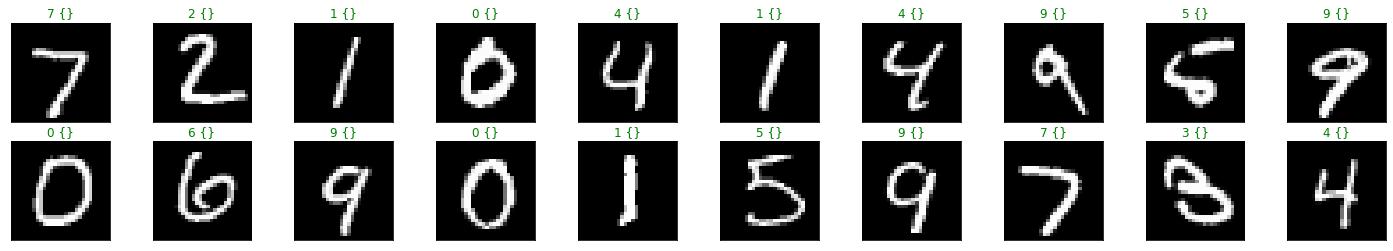

In [18]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1)
output = model(images)

_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # plot 2 rows, 10 col per row, creating index per row
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} {{}}".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))